In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as warn

from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import mutual_info_classif

sns.set()
warn.filterwarnings('ignore')

#### __Data Preprocessing, Analysis and Feature Selection__

__1. Data Preprocessing__

In [87]:
# Reading data
df1 = pd.read_csv('../data/dataset.csv')
df2 = pd.read_csv('../data/TCS.BO.csv')

# Adding price column to the indicator dataset
n = df1['Date'].size
df2Close = df2['Close'].to_list()
df2Date = df2['Date'].to_list()
prices = []
for i in range(n):
    df1Date = df1['Date'].iloc[i]
    price = df2Close[df2Date.index(df1Date)]
    prices.append(price)

df1['Price'] = prices
features = df1.columns[1:-1]

# Building the final datset to be used throughout
df = pd.concat([df1['Date'],df1['Price'],df1[features]], axis=1)
df.head()

,Date,Price,Volume,AO,ROC_12,ROC_26,ROC_50,ROC_200,EMA_12,EMA_26,...,WILLR_125,VWMA_14,VWMA_20,STOCH_d,STOCH_k,SMA_12,SMA_26,SMA_50,SMA_200,Signal
0,12-11-2002,36.974998,42304,7.932132,1.405545,-1.465698,-12.588655,-3.710945,43.493023,43.816629,...,-97.498357,44.108333,42.767381,0.145167,0.035445,43.116667,43.115866,44.26300,56.377938,WAIT
1,13-11-2002,36.625000,40440,-6.857685,2.268761,-4.498041,-15.561960,-2.104907,42.436404,43.283916,...,-97.959185,43.364286,42.346964,0.035870,0.033248,43.184375,43.049519,44.12800,56.374000,BUY
2,14-11-2002,37.062500,57552,-6.955552,2.382595,-1.133709,-13.582048,-1.690983,41.609649,42.823070,...,-97.383148,42.682262,41.974107,0.034403,0.034516,43.256250,43.033173,44.01150,56.370813,WAIT
3,15-11-2002,37.937500,76520,-6.895258,3.161111,1.369408,-8.639377,-1.043369,41.044703,42.461176,...,-96.231074,42.111191,41.688869,0.035050,0.037384,43.353125,43.052885,43.93975,56.368813,WAIT
4,18-11-2002,38.325001,133176,-6.703199,2.576117,0.590557,-6.008585,-0.583654,40.626287,42.154793,...,-95.720869,41.571548,41.445774,0.037440,0.040419,43.433333,43.061539,43.89075,56.367688,WAIT


__2. Feature Selection__

In [88]:
# Data split: 70% training, 30% testing
# Since it's a time-series data, we only need to select the first 70% data points for training
from math import floor
n = df['Date'].size
X_train = df.iloc[0:floor(n*0.7), 2:-1]
X_test = df.iloc[floor(n*0.7):, 2:-1]
y_train = df.iloc[0:floor(n*0.7), -1]
y_test = df.iloc[floor(n*0.7):, -1]

Text(0.5, 0, 'Mutual Information Gain')

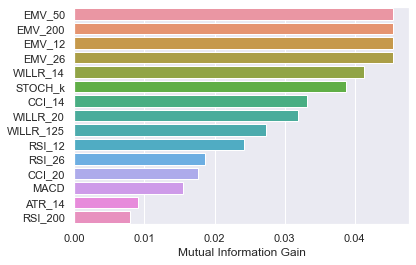

In [89]:
# Finding the mutual information gain of all features
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = df.columns[2:-1]
ig = mutual_info.sort_values(ascending=False)[:15]

# Plotting the information gains as a descending order list
sns.barplot(x=ig.to_list(),
y=['EMV_50','EMV_200','EMV_12','EMV_26','WILLR_14','STOCH_k','CCI_14','WILLR_20','WILLR_125','RSI_12','RSI_26',
'CCI_20','MACD','ATR_14','RSI_200'], orient='h')
plt.xlabel('Mutual Information Gain')

In [90]:
# List of top 15 features selected for use
features = ['EMV_50','EMV_200','EMV_12','EMV_26','WILLR_14','STOCH_k','CCI_14','WILLR_20','WILLR_125','RSI_12',
'RSI_26','CCI_20','MACD','ATR_14','RSI_200']
df = df[['Date','Price']+features+['Signal']]
X_train = df[features].iloc[0:floor(n*0.7)]
X_test = df[features].iloc[floor(n*0.7):]
y_train = df['Signal'].iloc[0:floor(n*0.7)]
y_test = df['Signal'].iloc[floor(n*0.7):]

<AxesSubplot:>

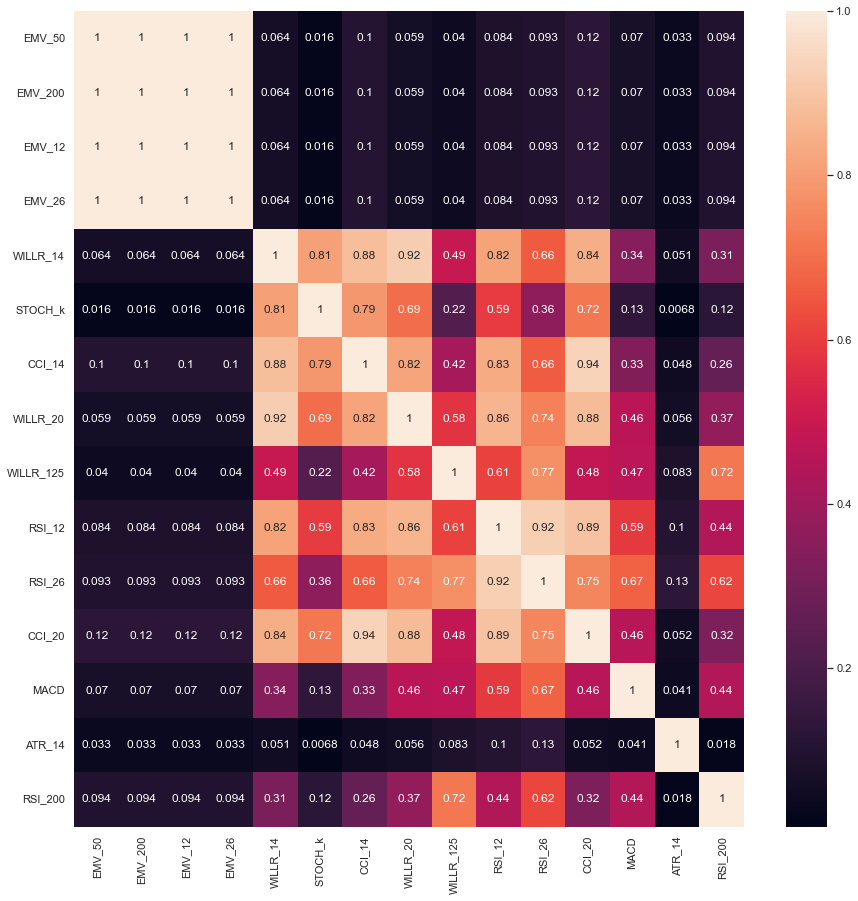

In [91]:
# Analysis of the extracted features
corr = df[features].corr().abs()
fig = plt.figure(figsize=(15,15))
sns.heatmap(data=corr, annot=True)

__Analysis:__ Since all the EMVs are fully correlated to each other, we can make do with any one of them. Let's take up EMV_50. So, the feature list can be further trimmed as follows: 

<AxesSubplot:>

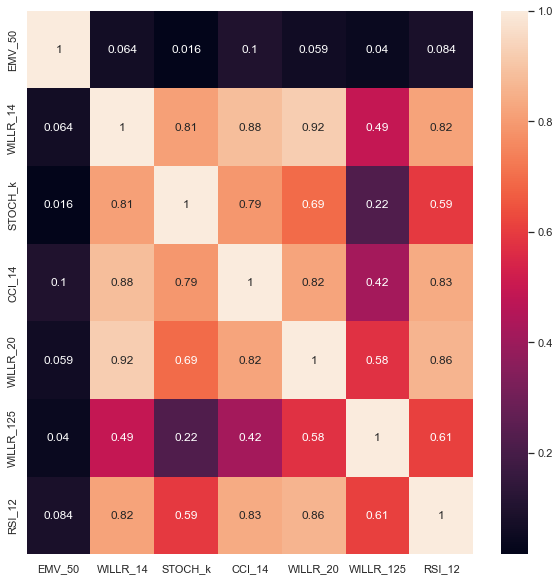

In [92]:
# Picking 10 out of these 15 based on absolute correlation 
features = ['EMV_50','WILLR_14','STOCH_k','CCI_14','WILLR_20','WILLR_125','RSI_12']
df = df[['Date','Price']+features+['Signal']]
X_train = df[features].iloc[0:floor(n*0.7)]
X_test = df[features].iloc[floor(n*0.7):]
y_train = df['Signal'].iloc[0:floor(n*0.7)]
y_test = df['Signal'].iloc[floor(n*0.7):]

# Finding absolute correlation matrix for these 10 selected features
corr = df[features].corr().abs()
fig = plt.figure(figsize=(10,10))
sns.heatmap(data=corr, annot=True)

### __Learning and Predicting__

__1. Logistic Regression__

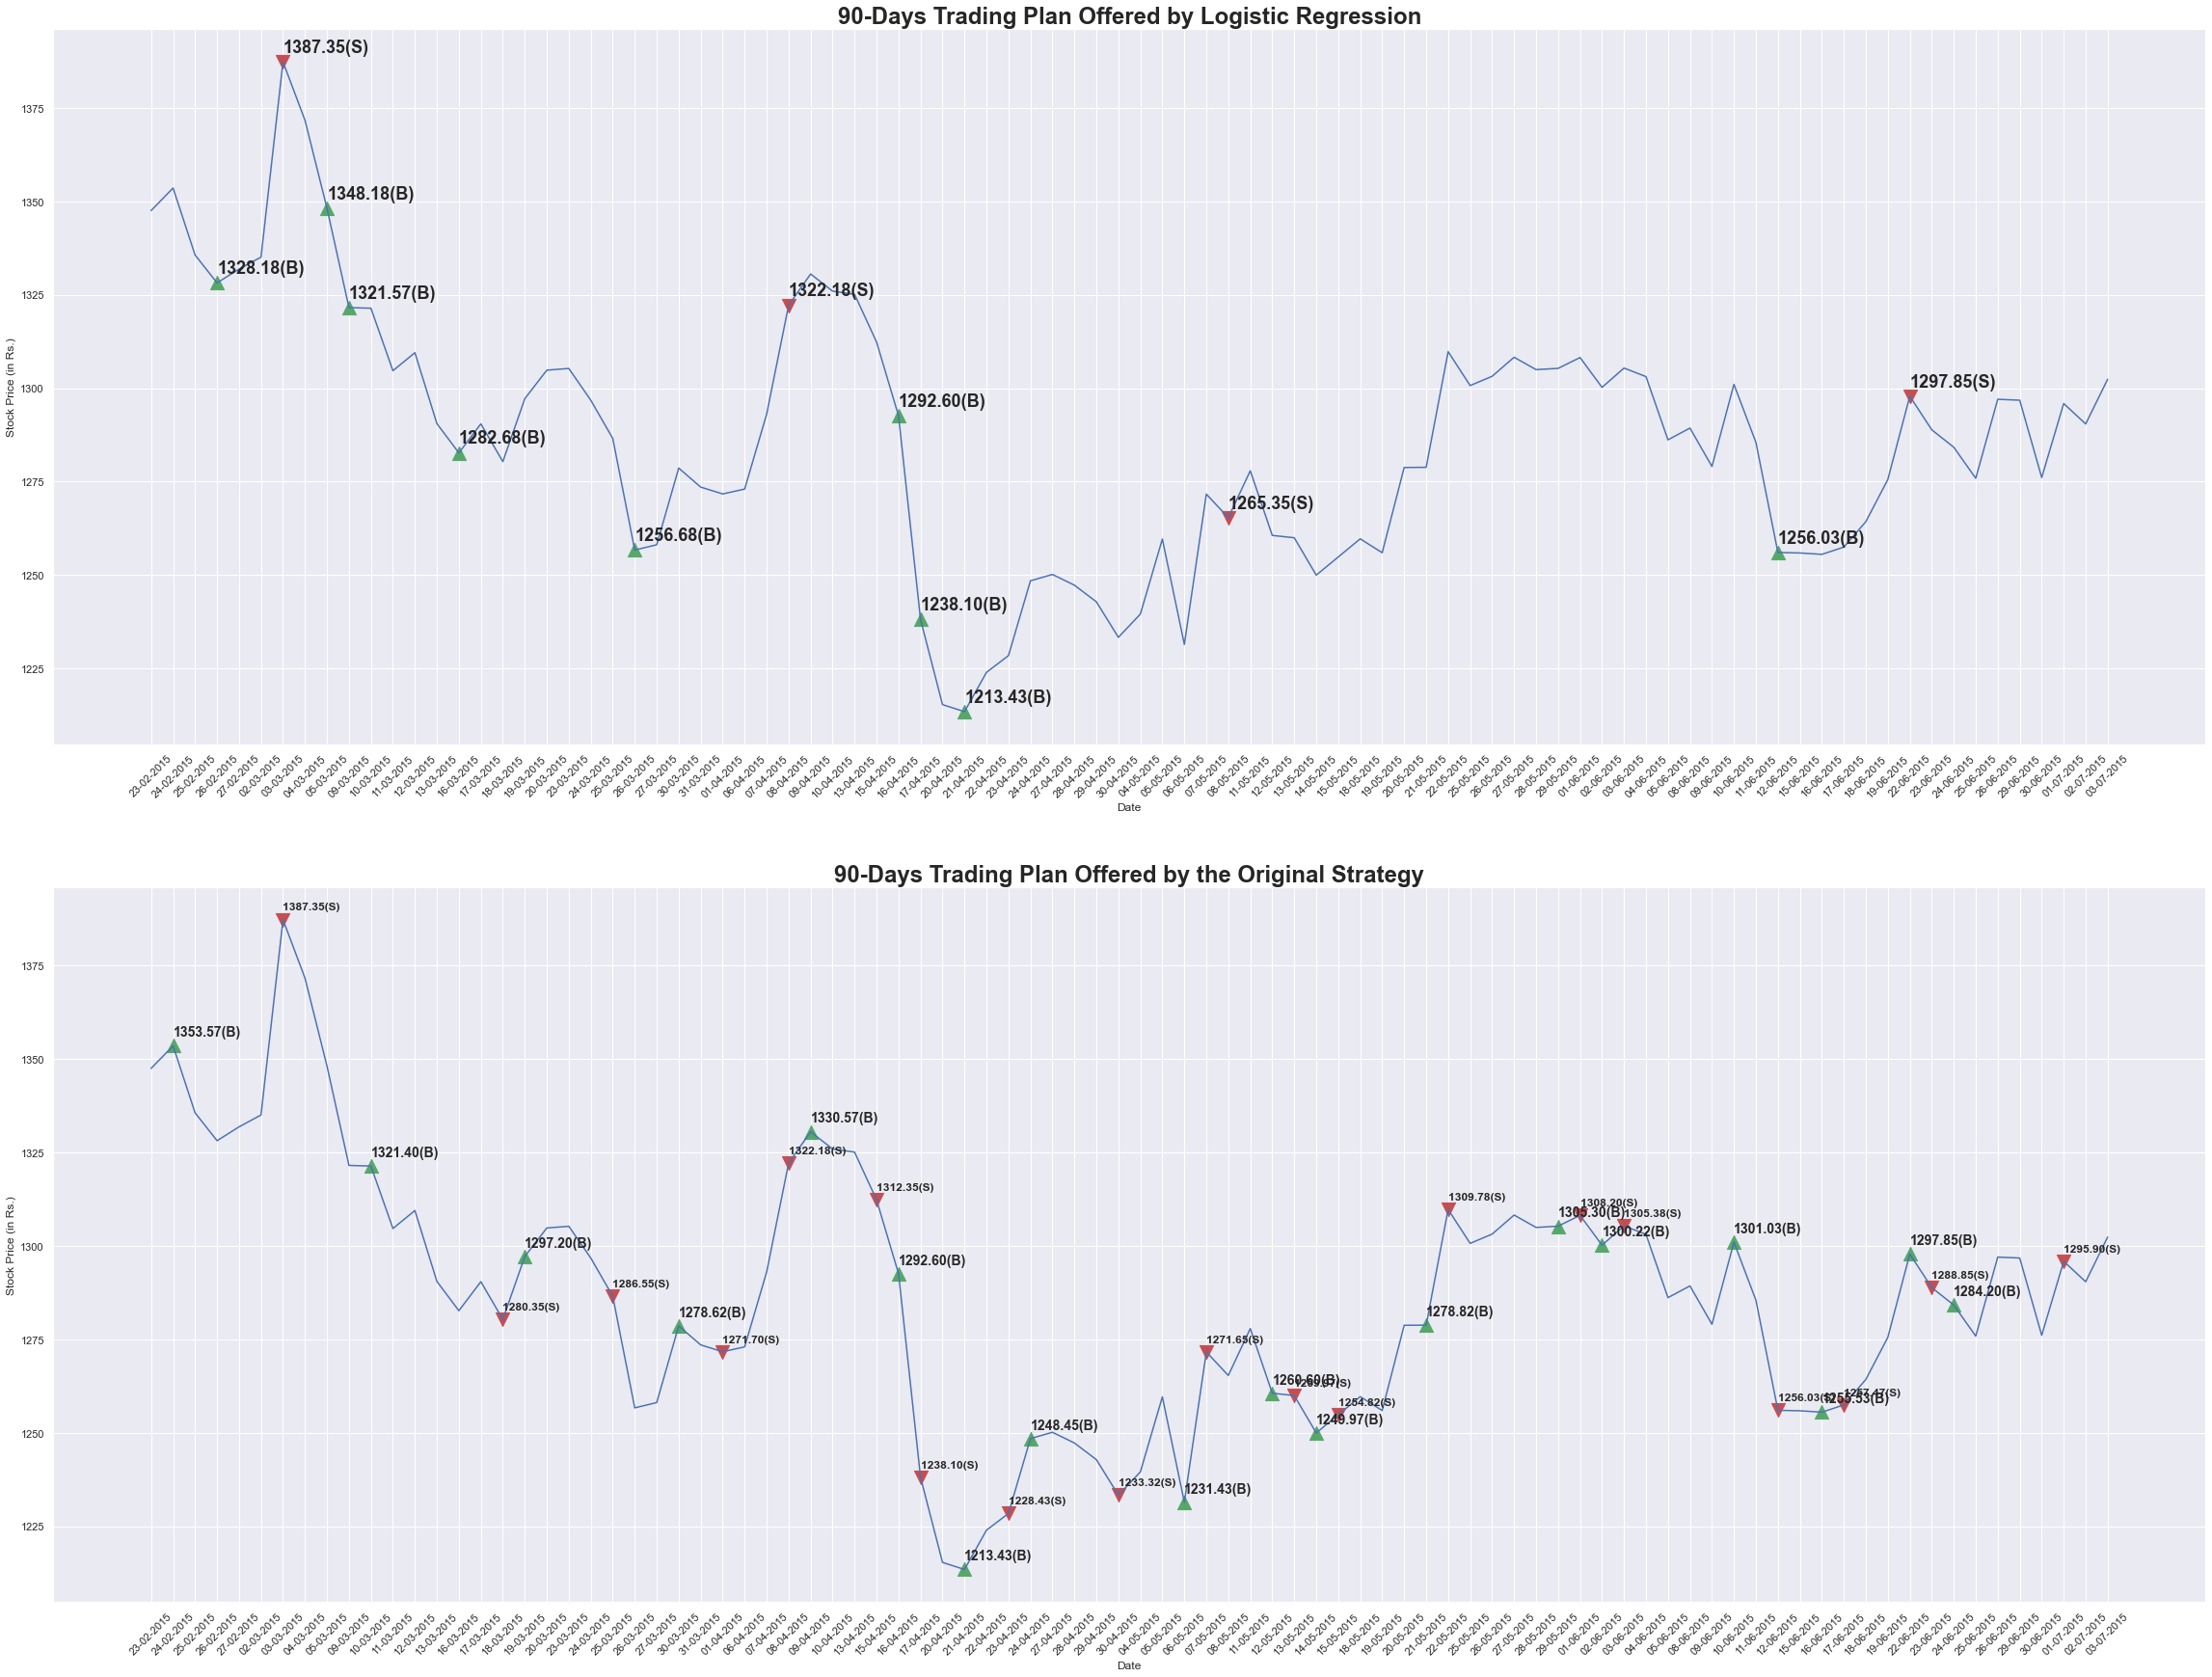

In [93]:
lr = LogisticRegression()   # Instantiating Logistic Regression
lr.fit(X_train, y_train)    # Training
predLR = lr.predict(X_test) # Generating signals over test set

nDays = 90  # N-days for signal visualization
# Visualizing N-days trading plan offered by the model
fig = plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays], df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays], '-')
i = 0
for x,y in zip(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays],df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays]):
    label = predLR[i]
    if(label=='WAIT'): label = ''
    elif(label=='BUY'): 
        label = '{:.2f}(B)'.format(y)
        plt.scatter(x=x, y=y, marker='^', c='g', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=18, fontweight='bold')
    else: 
        label = '{:.2f}(S)'.format(y)
        plt.scatter(x=x, y=y, marker='v', c='r', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=18, fontweight='bold')
    i = i+1
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price (in Rs.)')
plt.title('90-Days Trading Plan Offered by Logistic Regression', fontsize=24, fontweight='bold')

# Visualizing N-days trading plan offered by the original strategy
plt.subplot(2,1,2)
plt.plot(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays], df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays], '-')
i = 0
for x,y in zip(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays],df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays]):
    label = df['Signal'].iloc[i]
    if(label=='WAIT'): label = ''
    elif(label=='BUY'): 
        label = '{:.2f}(B)'.format(y)
        plt.scatter(x=x, y=y, marker='^', c='g', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=14, fontweight='bold')
    else: 
        label = '{:.2f}(S)'.format(y)
        plt.scatter(x=x, y=y, marker='v', c='r', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=12, fontweight='bold')
    i = i+1
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price (in Rs.)')
plt.title('90-Days Trading Plan Offered by the Original Strategy', fontsize=24, fontweight='bold')

plt.show()

__2. Multilayer Perceptron__

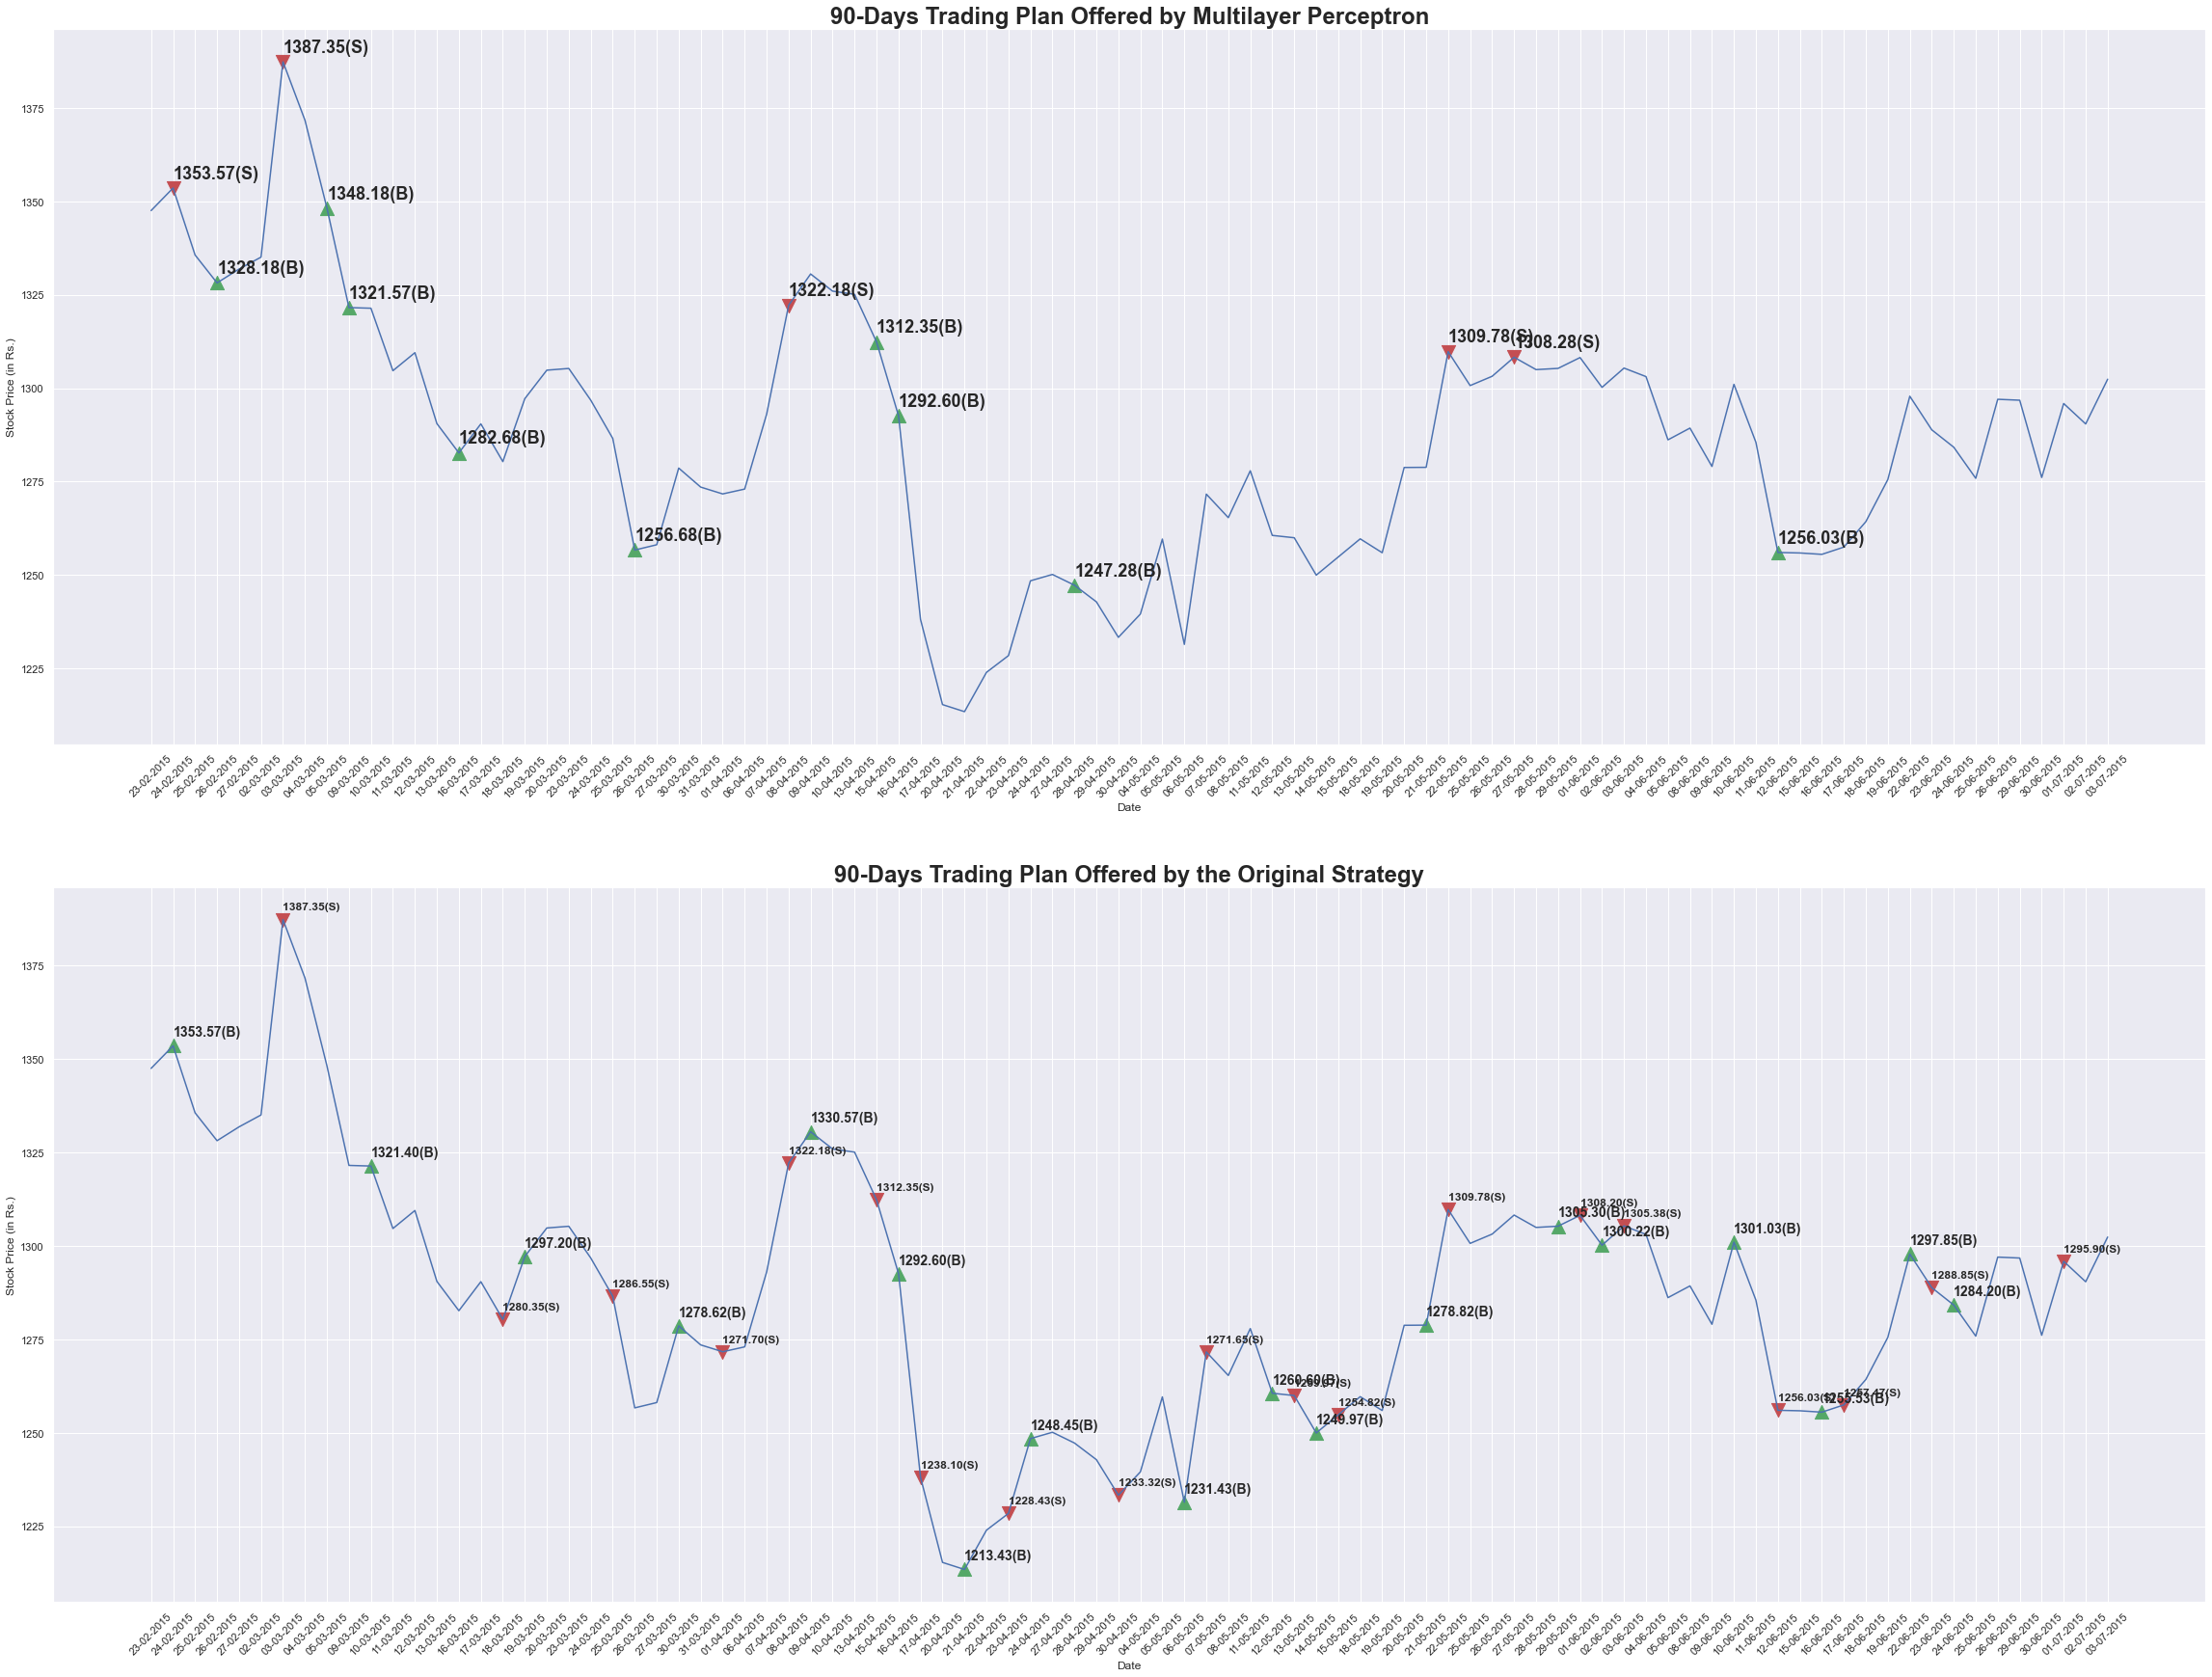

In [94]:
# Normalization parameters for the dataset
# NOTE: MLP works better if the input data follows normal distribution
mu = X_train.mean(axis=0)    
sig = X_train.std(axis=0)
# Normalizing the train and test sets
x_train = (X_train - mu)/sig
x_test = (X_test - mu)/sig

# Instantiating MLP Classifier: (InLayer:10, HL1:7, HL2:14, OutLayer:3)
mlp = MLPClassifier(hidden_layer_sizes=[7,14],activation='logistic',solver='lbfgs',random_state=0)
mlp.fit(x_train, y_train)   # Training
predMLP = mlp.predict(x_test)   # Generating signals over test set

nDays = 90
# Visualizing N-days trading plan offered by the model
fig = plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays], df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays], '-')
i = 0
for x,y in zip(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays],df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays]):
    label = predMLP[i]
    if(label=='WAIT'): label = ''
    elif(label=='BUY'): 
        label = '{:.2f}(B)'.format(y)
        plt.scatter(x=x, y=y, marker='^', c='g', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=18, fontweight='bold')
    else: 
        label = '{:.2f}(S)'.format(y)
        plt.scatter(x=x, y=y, marker='v', c='r', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=18, fontweight='bold')
    i = i+1
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price (in Rs.)')
plt.title('90-Days Trading Plan Offered by Multilayer Perceptron', fontsize=24, fontweight='bold')

# Visualizing N-days trading plan offered by the original strategy
plt.subplot(2,1,2)
plt.plot(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays], df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays], '-')
i = 0
for x,y in zip(df['Date'].iloc[floor(n*0.7):floor(n*0.7)+nDays],df['Price'].iloc[floor(n*0.7):floor(n*0.7)+nDays]):
    label = df['Signal'].iloc[i]
    if(label=='WAIT'): label = ''
    elif(label=='BUY'): 
        label = '{:.2f}(B)'.format(y)
        plt.scatter(x=x, y=y, marker='^', c='g', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=14, fontweight='bold')
    else: 
        label = '{:.2f}(S)'.format(y)
        plt.scatter(x=x, y=y, marker='v', c='r', s=200, alpha=1.0)
        plt.annotate(label, (x,y), textcoords='offset points', xytext=(0,10), ha='left', fontsize=12, fontweight='bold')
    i = i+1
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price (in Rs.)')
plt.title('90-Days Trading Plan Offered by the Original Strategy', fontsize=24, fontweight='bold')

plt.show()